1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import io
import requests

#colnames=['Default','Student','Balance','Income']
df =pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv", index_col=0)


#url = "https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv"

#s = requests.get(url).content
#df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

/Users/RaiDai/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df["default"] = df["default"].astype('category')
df["student"] = df["student"].astype('category')

df.dtypes

default    category
student    category
balance     float64
income      float64
dtype: object

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

In [3]:
df['default'] = df['default'].replace('No', 'default_No').replace('Yes', 'default_Yes')
df['student'] = df['student'].replace('No', 'student_No').replace('Yes', 'student_Yes')

df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])

df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)

#df_final=df_final.drop(['?'],1)
df_final.shape

#df_final.boxplot()

(10000, 6)

In [4]:
df_final.head()

,balance,income,default_No,default_Yes,student_No,student_Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


In [5]:
# downsample negative cases
indices = np.where(df.default == 'default_No')[0]
rng = np.random.RandomState(13)
rng.shuffle(indices)
n_pos = (df.default == 'default_Yes').sum()
df = df.drop(df.index[indices[n_pos:]])

df.head()

,default,student,balance,income
20,default_No,student_No,1095.072735,26464.631389
38,default_No,student_No,351.453472,35087.488648
61,default_No,student_No,766.234379,46478.294257
78,default_No,student_No,728.373251,45131.718265
79,default_No,student_No,76.991291,28392.093412


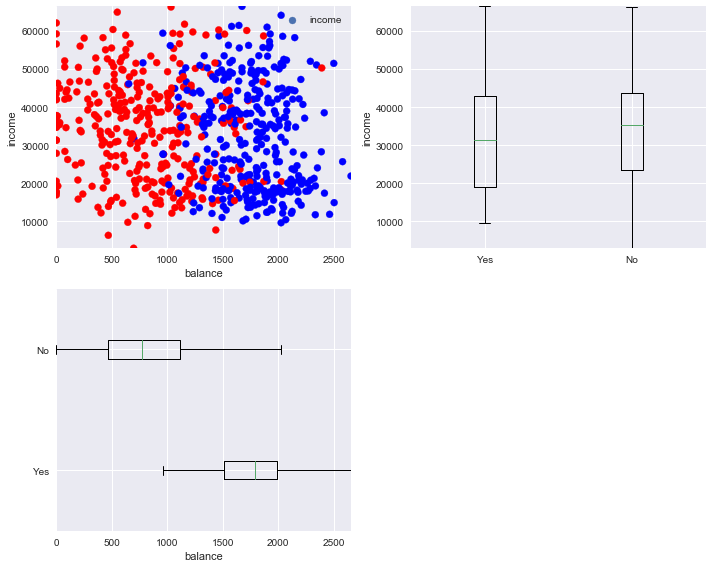

In [6]:
from matplotlib.colors import ListedColormap

# setup figure
plt.figure(figsize=(10, 8))

# scatter plot of balance (x) and income (y)
ax1 = plt.subplot(221)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(df.balance, df.income, c=(df.default == 'default_Yes'), cmap=cm_bright)        
ax1.set_xlim((df.balance.min(), df.balance.max()))
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xlabel('balance')
ax1.set_ylabel('income')
ax1.legend(loc='upper right')

# box plots for income
ax2 = plt.subplot(222)
ax2.boxplot([df.income[df.default == 'default_Yes'], df.income[df.default == 'default_No']])
ax2.set_ylim((df.income.min(), df.income.max()))
ax2.set_xticklabels(('Yes', 'No'))
ax2.set_ylabel('income')

# box plots for balance
ax3 = plt.subplot(223)
ax3.boxplot([df.balance[df.default == 'default_Yes'], df.balance[df.default == 'default_No']], vert=0)
ax3.set_xlim((df.balance.min(), df.balance.max()))
ax3.set_yticklabels(('Yes', 'No'))
ax3.set_xlabel('balance')
plt.tight_layout()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

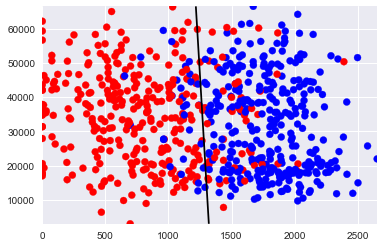

In [7]:
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))
    
# get feature/predictor matrix as numpy array
X = df[['balance', 'income']].values

# encode class labels
classes, y = np.unique(df.default.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

# fit OLS regression 
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, y)

# plot data and decision surface
ax = plt.gca()
ax.scatter(df.balance, df.income, c=(df.default == 'default_Yes'), cmap=cm_bright)

plot_surface(est, X[:, 0], X[:, 1], ax=ax)

Area under the ROC curve : 0.928191
Area under the ROC curve : 0.960949


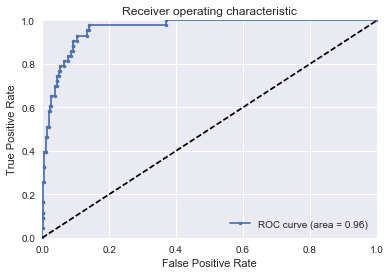

In [8]:
#from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# the larger operator will return a boolean array which we will cast as integers for fancy indexing
#y_pred = (2 * (est.predict(X) > 0.0)) - 1

#def confusion_matrix(y_test, y_pred):
#    cm = sk_confusion_matrix(y, y_pred)
#    cm = pd.DataFrame(data=cm, columns=[-1, 1], index=[-1, 1])
#    cm.columns.name = 'Predicted label'
#    cm.index.name = 'True label'
#    error_rate = (y_pred != y).mean()
#    print('error rate: %.2f' % error_rate)
#    return cm

#confusion_matrix(y, y_pred)

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
X = df_final[['balance', 'income']].values

# encode class labels
classes, y = np.unique(df_final.default_Yes.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

# Scale columns for regression.
scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)


# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.962152


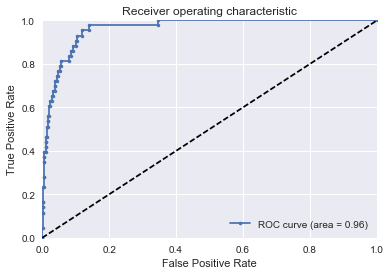

In [9]:
#X = df_final
X = df_final[['balance', 'income', 'student_Yes', 'student_No']].values

# encode class labels
classes, y = np.unique(df_final.default_Yes.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

# Scale columns for regression.
scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)


# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.960004
Area under the ROC curve : 0.960548
Area under the ROC curve : 0.961092
Area under the ROC curve : 0.961264
Area under the ROC curve : 0.961479
Area under the ROC curve : 0.961765
Area under the ROC curve : 0.961823
Area under the ROC curve : 0.961966
Area under the ROC curve : 0.962009
Area under the ROC curve : 0.962152
Area under the ROC curve : 0.962181
Area under the ROC curve : 0.962181
Area under the ROC curve : 0.962138
Area under the ROC curve : 0.962123
Area under the ROC curve : 0.962209
Area under the ROC curve : 0

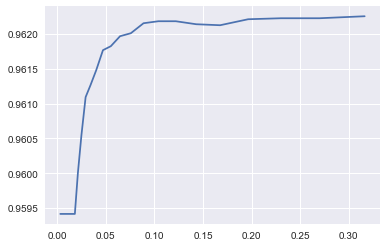

In [10]:
#optimizing with Ridge Regression
from sklearn.linear_model import Ridge

# Create linear regression object
alphas = np.logspace(-2.5,-0.5,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
plt.plot(alphas,scores)


In [16]:
from sklearn.model_selection import train_test_split
X = df_final[['balance', 'income', 'student_Yes', 'student_No']].values

# Scale columns for regression.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# encode class labels
classes, y = np.unique(df_final.default_Yes.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

n_samples, n_features = X.shape

half = int(n_samples/2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

print (X_train)
print (y_train)

[[-0.21883482  0.81318727 -0.64593619  0.64593619]
 [-0.03761593 -1.60549572  1.54814054 -1.54814054]
 [ 0.49241019 -0.13121225 -0.64593619  0.64593619]
 ..., 
 [ 2.4019434   1.25649771 -0.64593619  0.64593619]
 [ 0.25954139 -0.31587678 -0.64593619  0.64593619]
 [-0.38974928 -0.35094738 -0.64593619  0.64593619]]
[-1 -1 -1 ..., -1 -1 -1]


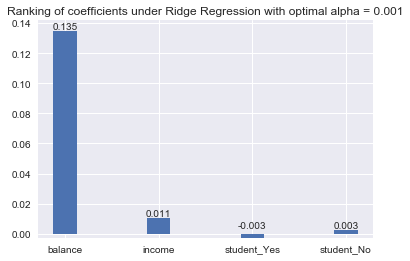

In [17]:
clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)
ind = np.arange(4)  
width = 0.250

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(ind, clf.coef_, width)
ax.set_xticks(ind)
ax.set_xticklabels(('balance', 'income', 'student_Yes', 'student_No'))
rects = ax.patches

for rect, label in zip(rects, clf.coef_):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.*height, np.round(label, 3), ha='center', va='bottom')
ax.set_title('Ranking of coefficients under Ridge Regression with optimal alpha = %.3f' %(alphas[opt_index]))

The added student variable adds only very marginal improvement.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [65]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        #print clf.coef_[0]
        coeffs.append(clf.coef_)
    return coeffs

coeffs=run_cv_coeffs(X,y,LogisticRegression,C=alpha,penalty='l1')

Area under the ROC curve : 0.944420


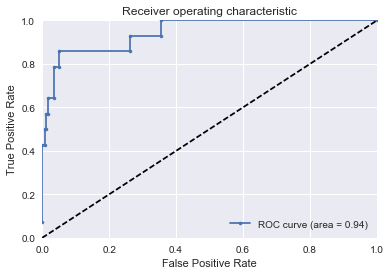

Area under the ROC curve : 0.844638


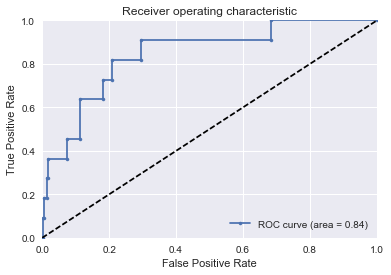

Area under the ROC curve : 0.903086


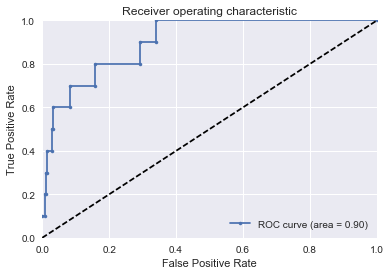

Area under the ROC curve : 0.944619


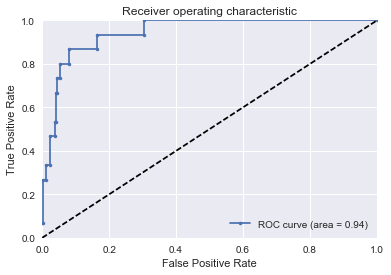

Area under the ROC curve : 0.939533


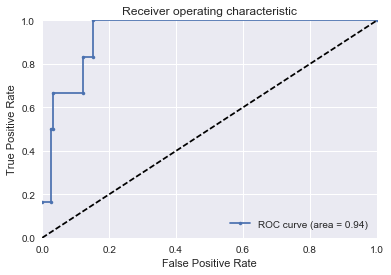

In [64]:
robust_check = [5, 10, 15, 20, 25]
for r in robust_check:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    clf = LogisticRegression(penalty='l1', C=100)
    clf.fit(X_train, y_train)
    fpr,tpr,roc_auc, thresholds = generate_auc(X_test,y_test,LogisticRegression,C=0.1,penalty='l1')
    generate_ROCplot(fpr,tpr,'LR',roc_auc)


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [19]:
from sklearn.tree import DecisionTreeRegressor

# get feature/predictor matrix as numpy array
X = df_final[['balance', 'income']].values

# encode class labels
classes, y = np.unique(df_final.default_Yes.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

# Fit regression model
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(X, y)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [20]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [35]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr, feature_names=['x'])

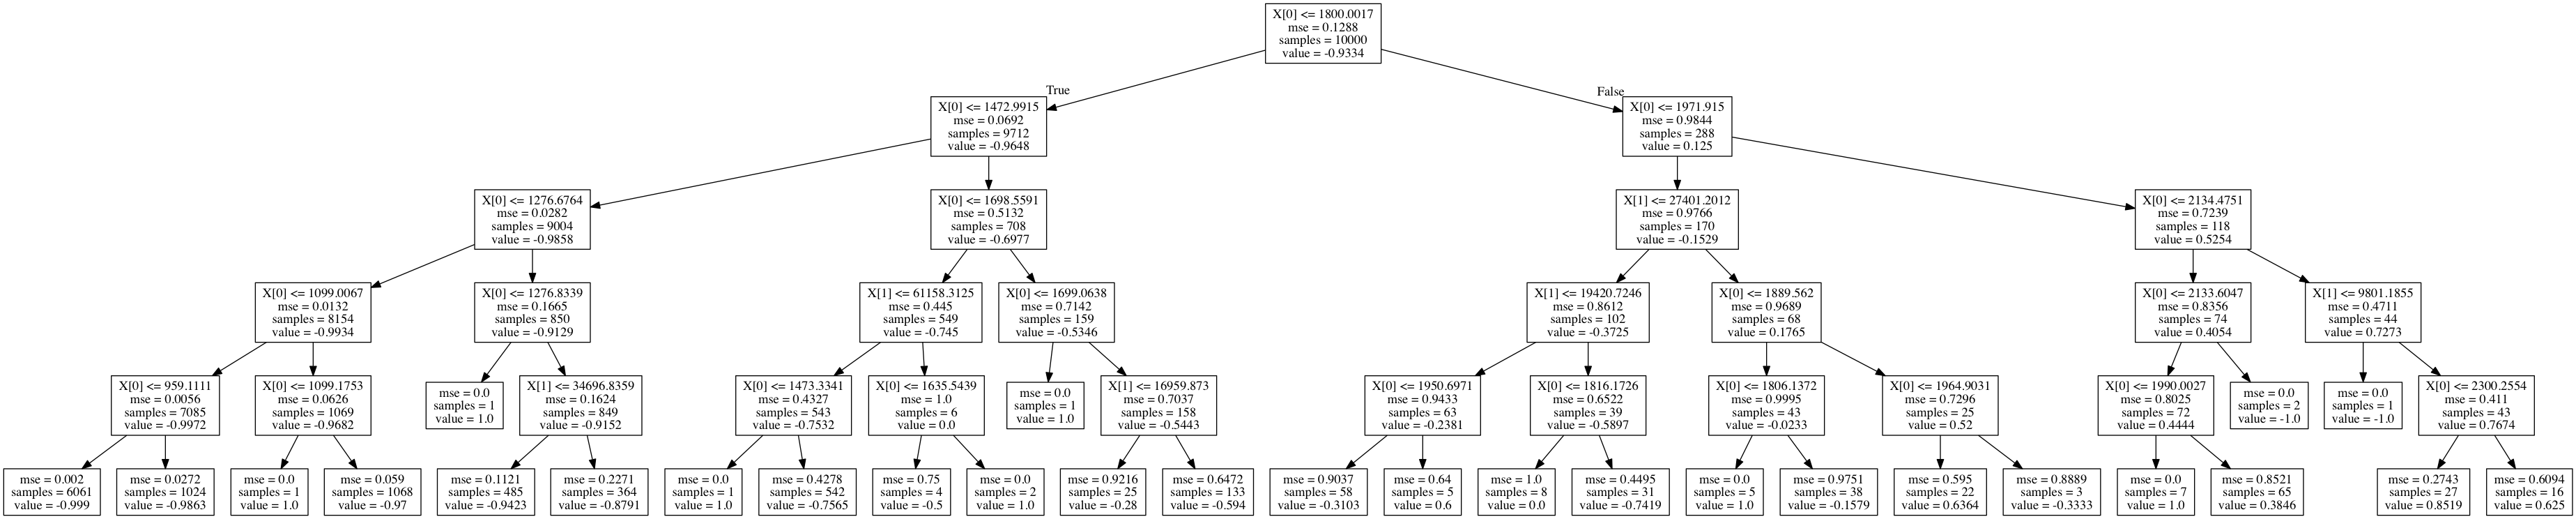

In [41]:
import pydotplus
from IPython.display import Image  

dot_data=export_graphviz(regr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

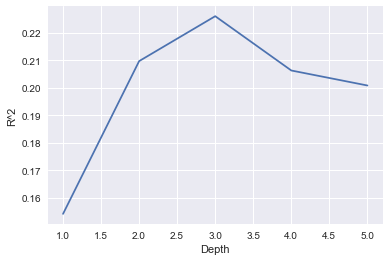

In [52]:
# Fit regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]


The optimal decision tree depth is 3.

Area under the ROC curve : 0.947743


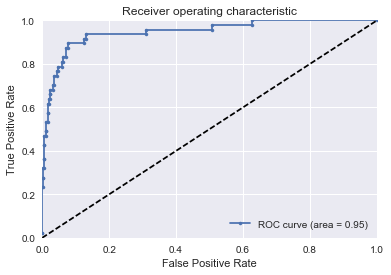

In [59]:
regr_opt = DecisionTreeRegressor(max_depth=n_opt)
regr_opt.fit(X, y)

fpr,tpr,roc_auc, thresholds = generate_auc(X_train,y_train,LogisticRegression,C=0.1,penalty='l1')

generate_ROCplot(fpr,tpr,'LR',roc_auc)